#### Specify Jupyter extensions
`matplotlib inline` allows visualizing the plots in the notebook.
`autoreload` allows external modules to be reloaded automatically to keep track of any changes made therein.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import the Python libraries and custom modules as needed

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline
import random

# Import the custom module for helper functions.
from utils import *

In [3]:
# Specifying seed value for reproducibility.

seedval = 8888
np.random.seed(seedval)

In [4]:
# Specifying project directories.

savedir = 'SavedFigs/'
datadir = 'Data/'

# Question 1

## Generating synthetic data

We use the following polynomial:

y = f(x) = 0.4 x^3 - 2 x^2 + 0.6 x + 3

We generate 20 equally spaced points in the range [-1.4, 5.4].

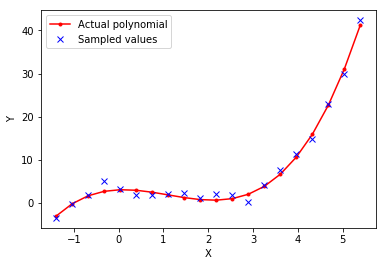

In [5]:
# Number of samples to be generated for the synthetic data.
n_samples = 20

# Coefficients of the polynomial as mentioned above.
poly_coeffs = np.array([0.4, -2, 0.6, 3])

# Inferring the polynomial order from the shape of the coefficients.
poly_order = poly_coeffs.shape[0] - 1

# Generate equally spaced points in the specified range.
X = np.linspace(-1.4, 5.4, n_samples).reshape(-1, 1)

# Generate polynomial features for these input points.
poly_X = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, poly_order+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        poly_X = np.hstack((poly_X, X ** i))

# Finally, add ones to the features by exponentiating with 0.
poly_X = np.hstack((poly_X, X ** 0))

# Generate labels for the generated data points using the coefficients.
Y_clean = (poly_X @ poly_coeffs.T).reshape(-1, 1)

# Add Gaussian noise to corrupt the labels.
Y_noisy = Y_clean + np.random.normal(0, 1, (n_samples, 1))

# Plot the actual polynomial and the sampled values.
plt.plot(X, Y_clean, 'r.-', label='Actual polynomial')
plt.plot(X, Y_noisy, 'bx', label='Sampled values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_1.png', dpi=300, bbox_inches='tight')
plt.show()

## Two-parameter regression model and its cost surface

the parameters are
 [[-0.71079588]
 [ 4.15566943]]


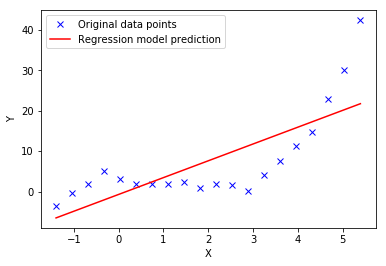

In [6]:
# Add ones to the sampled points to generate features for the 2-parameter regression model
X_linreg = np.insert(X, 0, np.ones(n_samples), axis=1)

# Use the analytical method to calculate the model parameters
linreg_params = np.linalg.inv(X_linreg.T.dot(X_linreg)).dot(X_linreg.T).dot(Y_noisy)

# Predict labels for the sampled points based on the calculated parameters.
Y_linreg_pred = X_linreg.dot(linreg_params) 

print("the parameters are\n", linreg_params)

# Plot the predictions versus the actual data points.
plt.plot(X, Y_noisy, 'bx', label='Original data points')
plt.plot(X_linreg[:,1], Y_linreg_pred, 'r-', label='Regression model prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_2.png', dpi=300, bbox_inches='tight')
plt.show()

Based on the parameter values calculated above, we will plot the cost surface in the range of [-10, 10] for both the parameters.

In [7]:
# Generate equally spaced grid points for (w,b) to calculate cost.
w_lim = b_lim = np.arange(-10, 10, 0.1)

# Next, in order to calculate the cost at all points, we generate
# the grid by taking a Cartesian product of the values in w and b.
# This line is inspired by https://stackoverflow.com/a/11144716
params_scan = np.transpose([np.tile(w_lim, len(b_lim)), 
                            np.repeat(b_lim, len(w_lim))
                           ]).T

# Next, we use our custom cost_fn() to calculate the cost at
# all points in the grid above.
cost_values = cost_fn(params_scan, X_linreg.T, Y_noisy)

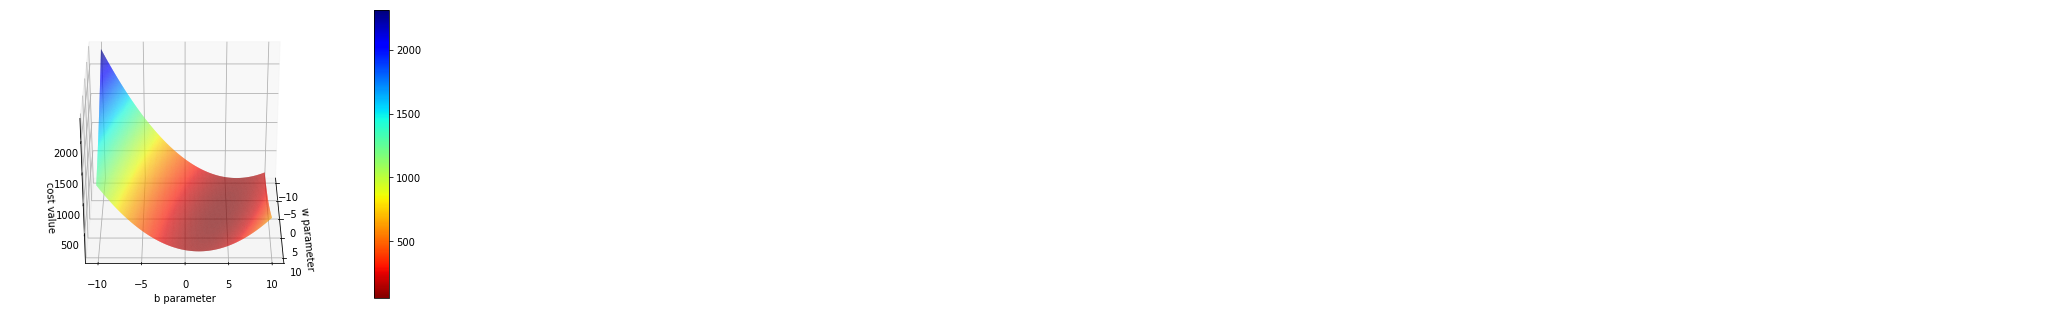

In [8]:
# Create the matplotlib 3D figure.
fig = plt.figure()
ax = Axes3D(fig)

# Plot the surface of cost values.
surf = ax.plot_trisurf(params_scan[0,:], params_scan[1,:], cost_values, cmap='jet_r', linewidth=0.1)

# Add a colorbar for improved readability.
fig.colorbar(surf)

# Specify axis labels.
ax.set_xlabel('w parameter')
ax.set_ylabel('b parameter')
ax.set_zlabel('cost value')

# Limit xticks and yticks for improved readability.
plt.xticks(np.array([-10., -5., 0., 5., 10.]))
plt.yticks(np.array([-10., -5., 0., 5., 10.]))

# We also generate an animation to show the 3D surface.
# Inspired by https://stackoverflow.com/q/51457738
# Please uncomment next 4 lines to evaluate it if needed.

# def rotate(angle):
#     ax.view_init(azim=angle)
# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 30), interval=10)
# rot_animation.save(savedir + 'Q1_3.gif', dpi=80, writer='imagemagick')

# fig.savefig(savedir + 'Q1_3.png', dpi=300, bbox_inches='tight')

plt.show()

## Two-parameter regression model using gradient descent and the model parameters on the cost surface

In [9]:
# We want to fit a 2 parameter model, so an order 1 polynomial.
fit_poly_order = 1

# Prepare features by adding ones to the data points
fit_X = np.hstack((X, X ** 0))

# Perform gradient descent to fit a two-parameter regression model to this data.
learned_params, traced_params, traced_cost = grad_descent(fit_X.T,
                                                          Y_noisy,
                                                          n_params=(fit_poly_order + 1),
                                                          batch_size=-1,
                                                          lr=5e-5, n_epochs=int(1e6)
                                                         )

# Next, we overlay the model parameters for each iteration on the cost surface.
curve = ax.plot(traced_params[:,0].reshape(-1), 
                traced_params[:,1].reshape(-1), 
                traced_cost.reshape(-1), 
                'k-', zorder=3)

# We also generate an animation to show the 3D surface.
# Inspired by https://stackoverflow.com/q/51457738
# Please uncomment next 4 lines to evaluate it if needed.

# def rotate(angle):
#     ax.view_init(azim=angle)
# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 30), interval=10)
# rot_animation.save(savedir + 'Q1_4.gif', dpi=80, writer='imagemagick')

# fig.savefig(savedir + 'Q1_4.png', dpi=300, bbox_inches='tight')

plt.show()

## Linear polynomial regression using analytical method

the parameters are
 [[ 0.53634956]
 [-2.1246754 ]
 [ 0.61699189]
 [ 3.37307521]]


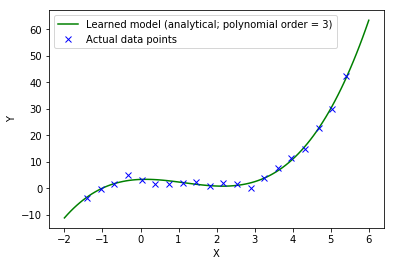

In [10]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_ana = 3

# Generate polynomial features for these input points.
fit_X_ana = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_ana+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_ana = np.hstack((fit_X_ana, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_ana = np.hstack((fit_X_ana, X ** 0))

# Use the analytical method to find model parameters.
poly_reg_param_ana = analytical_linreg(fit_X_ana.T, Y_noisy)

print("the parameters are\n", poly_reg_param_ana)

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_ana, yfit_ana = generate_data_eval(100, poly_reg_param_ana, -2, 6)

plt.plot(xfit_ana, yfit_ana, 'g-', 
         label='Learned model (analytical; polynomial order = {:d})'.format(fit_poly_order_ana)
        )
plt.plot(X, Y_noisy, 'bx', label='Actual data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_5.png', dpi=300, bbox_inches='tight')
plt.show()

## Linear polynomial regression using gradient descent

the parameters are
 [[ 0.43088552]
 [-1.98492865]
 [ 0.59566546]
 [ 3.05795251]]


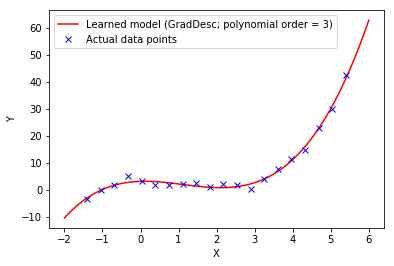

In [11]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

print("the parameters are\n", poly_reg_param_gd)

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd, yfit_gd = generate_data_eval(100, poly_reg_param_gd, -2, 6)

plt.plot(xfit_gd, yfit_gd, 'r-', 
         label='Learned model (GradDesc; polynomial order = {:d})'.format(fit_poly_order_gd)
        )
plt.plot(X, Y_noisy, 'bx', label='Actual data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_6.png', dpi=300, bbox_inches='tight')
plt.show()

## Comparing models obtained using analytical method and gradient descent

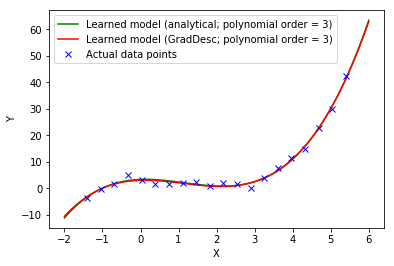

In [12]:
plt.plot(xfit_ana, yfit_ana, 'g-', 
         label='Learned model (analytical; polynomial order = {:d})'.format(fit_poly_order_ana)
        )
plt.plot(xfit_gd, yfit_gd, 'r-', 
         label='Learned model (GradDesc; polynomial order = {:d})'.format(fit_poly_order_gd)
        )
plt.plot(X, Y_noisy, 'bx', label='Actual data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_7.png', dpi=300, bbox_inches='tight')
plt.show()

## Studying the effect of learning rate in gradient descent

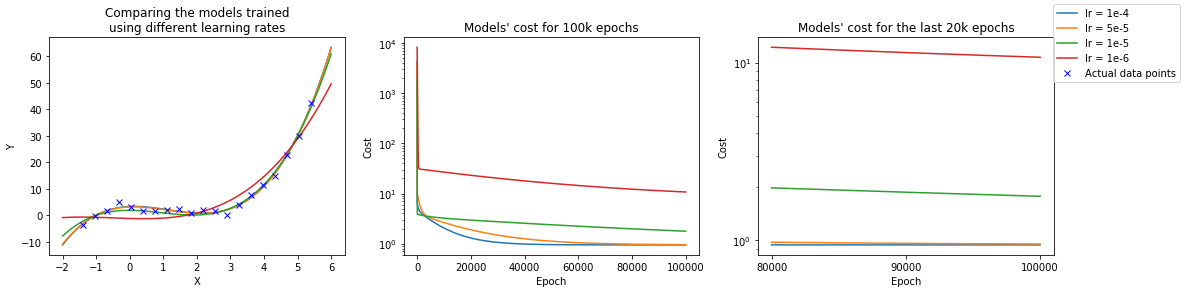

In [13]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters, but 
# for multiple models, each trained with a different
# learning rate. 

# Creating dictionaries to keep track of experiments.
poly_reg_param_gd, poly_reg_cost_gd = {}, {}
xfit_gd, yfit_gd = {}, {}

# List of learning rates to explore
lrs = ['1e-4', '5e-5', '1e-5', '1e-6']

# Loop over all learning rates and train regression
# model with each, tracking their parameters and cost.
for lr in lrs:
    # Except learning rate, all other hyperparameters
    # remain the same for the models.
    poly_reg_param_gd[str(lr)], _, poly_reg_cost_gd[str(lr)] = grad_descent(fit_X_gd.T, 
                                                                            Y_noisy, 
                                                                            n_params=(fit_poly_order_gd + 1),
                                                                            batch_size=-1,
                                                                            lr=float(lr),
                                                                            n_epochs=int(1e5))
    # Generate data points and corresponding labels to visualize.
    xfit_gd[str(lr)], yfit_gd[str(lr)] = generate_data_eval(100, 
                                                            poly_reg_param_gd[str(lr)], 
                                                            -2, 6)

# Next, we visualize the results.
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# First, we visualize the fitted models versus the actual data points.
for lr in lrs:
    ax[0].plot(xfit_gd[str(lr)], yfit_gd[str(lr)],
             label='lr = {:s}'.format(lr)
        )
ax[0].plot(X, Y_noisy, 'bx', label='Actual data points')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].title.set_text('Comparing the models trained\nusing different learning rates')

# Next, we visualize the cost curves for all the models.
for lr in lrs:
    ax[1].plot(poly_reg_cost_gd[str(lr)],
             label='lr = {:s}'.format(lr)
        )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Cost')
# We use the log scale on the Y-axis to clearly 
# show the difference in cost values.
ax[1].set_yscale('log')
ax[1].title.set_text('Models\' cost for 100k epochs')

# Finally, we selectively visualize only the last
# 20k epochs to show that there is an order of
# magnitude difference between different learning
# rates.
for lr in lrs:
    ax[2].plot(np.arange(80000, 100000),
               poly_reg_cost_gd[str(lr)][-20000:],
             label='lr = {:s}'.format(lr)
        )
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Cost')
# We limit the xticks for improved readability.
ax[2].set_xticks(np.array([80000, 90000, 100000]))
# We use the log scale on the Y-axis to clearly 
# show the difference in cost values.
ax[2].set_yscale('log')
ax[2].title.set_text('Models\' cost for the last 20k epochs')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# plt.savefig(savedir + 'Q1_8.png', dpi=300, bbox_inches='tight')
plt.show()

## Studying the effect of batch size in gradient descent

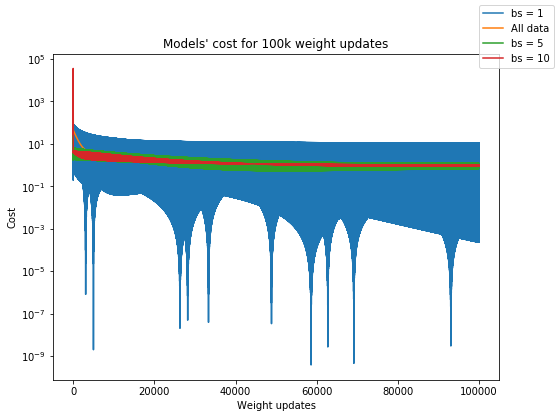

In [14]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters, but 
# for multiple models, each trained with a different
# batch size. 

# Creating a dictionary to keep track of experiments.
poly_reg_cost_gd = {}

# List of batch sizes to explore
b_sizes = {
    'All data': -1,
    'bs = 1': 1,
    'bs = 5': 5,
    'bs = 10':10
}

# Loop over all learning rates and train regression
# model with each, tracking their parameters and cost.
for bs in b_sizes.keys():
    # Except batch size, all other hyperparameters
    # remain the same for the models.
    _, _, poly_reg_cost_gd[bs] = grad_descent(fit_X_gd.T, 
                                                Y_noisy, 
                                                n_params=(fit_poly_order_gd + 1),
                                                batch_size=b_sizes[bs],
                                                lr=5e-5,
                                                n_epochs=int(1e5))
    
# Next, we visualize the results.
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Next, we visualize the cost curves for all the models.
for bs in b_sizes.keys():
    ax.plot(poly_reg_cost_gd[bs][:100000],
             label=bs
        )
ax.set_xlabel('Weight updates')
ax.set_ylabel('Cost')
# We use the log scale on the Y-axis to clearly 
# show the difference in cost values.
ax.set_yscale('log')
ax.title.set_text('Models\' cost for 100k weight updates')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# plt.savefig(savedir + 'Q1_9.png', dpi=300, bbox_inches='tight')
plt.show()

## Studying the effect of number of training samples in gradient descent

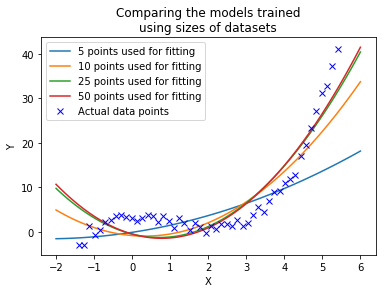

In [17]:
# Here, we generate a large number of data points from
# which we will # subsample to vary the number of
# training examples
n_samples_large = 50
# Generate these points along with their labels
X_large, _, Y_noisy_large = generate_data(n_samples_large, poly_coeffs, -1.4, 5.4)

# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 2

# Generate polynomial features for these input points.
fit_X_gd = X_large
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X_large ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X_large ** 0))

# Use gradient descent to find model parameters, but 
# for multiple models, each trained with a dataset
# of different size. 

# Creating dictionaries to keep track of experiments.
poly_reg_param_gd = {}
xfit_gd, yfit_gd = {}, {}

# List of dataset sizes to explore
dset_size = [5, 10, 25, 50]

# Loop over all learning rates and train regression
# model with each, tracking their parameters and cost.
for ds in dset_size:
    # Except dataset size, all other hyperparameters
    # remain the same for the models.
    # We change dataset size by changing the sampling 
    # frequency from the entire dataset.
    poly_reg_param_gd[str(ds)], _, _ = grad_descent(fit_X_gd[::(n_samples_large // ds)].T, 
                                                Y_noisy_large[::(n_samples_large // ds)], 
                                                n_params=(fit_poly_order_gd + 1),
                                                batch_size=-1,
                                                lr=5e-5,
                                                n_epochs=int(1e5))
    # Generate data points and corresponding labels to visualize.
    xfit_gd[str(ds)], yfit_gd[str(ds)] = generate_data_eval(100, 
                                                            poly_reg_param_gd[str(ds)], 
                                                            -2, 6)
    
# Next, we visualize the results.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# We visualize the fitted models versus the actual data points.
for ds in dset_size:
    ax.plot(xfit_gd[str(ds)], yfit_gd[str(ds)],
             label='{:d} points used for fitting'.format(ds)
        )
ax.plot(X_large, Y_noisy_large, 'bx', label='Actual data points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.title.set_text('Comparing the models trained\nusing sizes of datasets')
plt.legend()

# plt.savefig(savedir + 'Q1_10_2.png', dpi=300, bbox_inches='tight')
plt.show()

## Plotting model parameters for each iteration

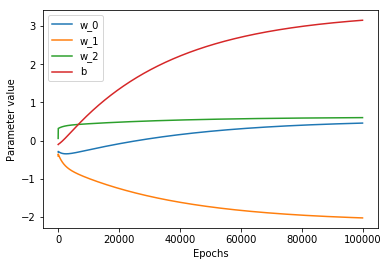

In [18]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
_, traced_params, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the values of these parameters
# versus epochs.

for param in range(fit_poly_order_gd):
    plt.plot(traced_params[:,param], label='w_{:d}'.format(param))

# Plotting the bias term.
plt.plot(traced_params[:,fit_poly_order_gd], label='b')

plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.legend()

# plt.savefig(savedir + 'Q1_11.png', dpi=300, bbox_inches='tight')
plt.show()

## Repeating the experiment for data sampled from a 2nd order polynomial

### Generating data points

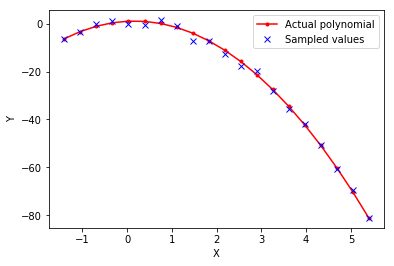

In [19]:
# Number of samples to be generated for the synthetic data.
n_samples = 20

# Coefficients of the polynomial as mentioned above.
poly_coeffs = np.array([1, -3, 1])

# Inferring the polynomial order from the shape of the coefficients.
poly_order = poly_coeffs.shape[0] - 1

# Generate equally spaced points in the specified range.
X = np.linspace(-1.4, 5.4, n_samples).reshape(-1, 1)

# Generate polynomial features for these input points.
poly_X = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, poly_order+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        poly_X = np.hstack((poly_X, X ** i))

# Finally, add ones to the features by exponentiating with 0.
poly_X = np.hstack((poly_X, X ** 0))

# Generate labels for the generated data points using the coefficients.
Y_clean = (poly_X @ poly_coeffs.T).reshape(-1, 1)

# Add Gaussian noise to corrupt the labels.
Y_noisy = Y_clean + np.random.normal(0, 1, (n_samples, 1))

# Plot the actual polynomial and the sampled values.
plt.plot(X, Y_clean, 'r.-', label='Actual polynomial')
plt.plot(X, Y_noisy, 'bx', label='Sampled values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_12.png', dpi=300, bbox_inches='tight')
plt.show()

### Fitting a 2nd order polynomial using analytical method

In [20]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_ana = 2

# Generate polynomial features for these input points.
fit_X_ana = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_ana+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_ana = np.hstack((fit_X_ana, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_ana = np.hstack((fit_X_ana, X ** 0))

# Use the analytical method to find model parameters.
poly_reg_param_ana = analytical_linreg(fit_X_ana.T, Y_noisy)

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_ana, yfit_ana = generate_data_eval(100, poly_reg_param_ana, -2, 6)

### Fitting 1st, 2nd, and 3rd order polynomials using gradient descent

#### 1st order polynomial

In [21]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 1

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_1, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_1, yfit_gd_1 = generate_data_eval(100, poly_reg_param_gd_1, -2, 6)

#### 2nd order polynomial

In [22]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 2

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_2, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_2, yfit_gd_2 = generate_data_eval(100, poly_reg_param_gd_2, -2, 6)

#### 3rd order polynomial

In [23]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_3, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_3, yfit_gd_3 = generate_data_eval(100, poly_reg_param_gd_3, -2, 6)

### Visualizing the fitted models

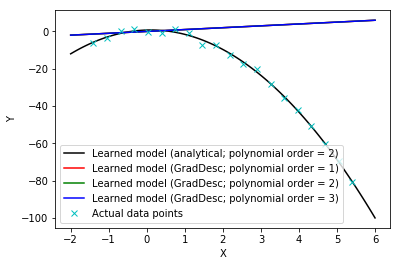

In [24]:
plt.plot(xfit_ana, yfit_ana, 'k-', 
         label='Learned model (analytical; polynomial order = {:d})'.format(fit_poly_order_ana)
        )
plt.plot(xfit_gd_1, xfit_gd_1, 'r-', 
         label='Learned model (GradDesc; polynomial order = 1)'
        )
plt.plot(xfit_gd_2, xfit_gd_2, 'g-', 
         label='Learned model (GradDesc; polynomial order = 2)'
        )
plt.plot(xfit_gd_3, xfit_gd_3, 'b-', 
         label='Learned model (GradDesc; polynomial order = 3)'
        )
plt.plot(X, Y_noisy, 'cx', label='Actual data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_13.png', dpi=300, bbox_inches='tight')
plt.show()

## Repeating the experiment for data sampled from a 1st order polynomial

### Generating data points

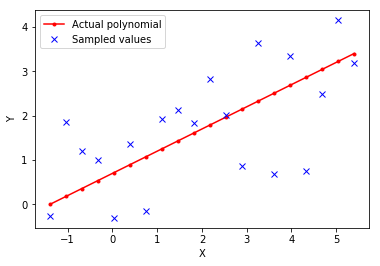

In [25]:
# Number of samples to be generated for the synthetic data.
n_samples = 20

# Coefficients of the polynomial as mentioned above.
poly_coeffs = np.array([0.5, 0.7])

# Inferring the polynomial order from the shape of the coefficients.
poly_order = poly_coeffs.shape[0] - 1

# Generate equally spaced points in the specified range.
X = np.linspace(-1.4, 5.4, n_samples).reshape(-1, 1)

# Generate polynomial features for these input points.
poly_X = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, poly_order+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        poly_X = np.hstack((poly_X, X ** i))

# Finally, add ones to the features by exponentiating with 0.
poly_X = np.hstack((poly_X, X ** 0))

# Generate labels for the generated data points using the coefficients.
Y_clean = (poly_X @ poly_coeffs.T).reshape(-1, 1)

# Add Gaussian noise to corrupt the labels.
Y_noisy = Y_clean + np.random.normal(0, 1, (n_samples, 1))

# Plot the actual polynomial and the sampled values.
plt.plot(X, Y_clean, 'r.-', label='Actual polynomial')
plt.plot(X, Y_noisy, 'bx', label='Sampled values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_14.png', dpi=300, bbox_inches='tight')
plt.show()

### Fitting a 1st order polynomial using analytical method

In [26]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_ana = 1

# Generate polynomial features for these input points.
fit_X_ana = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_ana+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_ana = np.hstack((fit_X_ana, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_ana = np.hstack((fit_X_ana, X ** 0))

# Use the analytical method to find model parameters.
poly_reg_param_ana = analytical_linreg(fit_X_ana.T, Y_noisy)

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_ana, yfit_ana = generate_data_eval(100, poly_reg_param_ana, -2, 6)

### Fitting 1st, 2nd, and 3rd order polynomials using gradient descent

#### 1st order polynomial

In [27]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 1

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_1, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_1, yfit_gd_1 = generate_data_eval(100, poly_reg_param_gd_1, -2, 6)

#### 2nd order polynomial

In [28]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 2

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_2, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_2, yfit_gd_2 = generate_data_eval(100, poly_reg_param_gd_2, -2, 6)

#### 3rd order polynomial

In [29]:
# Specify the order of polynomial to be fit over the data.
fit_poly_order_gd = 3

# Generate polynomial features for these input points.
fit_X_gd = X
# Traverse over all the exponent values of the polynomial.
for i in range(1, fit_poly_order_gd+1):
    # Skip exponent = 1 since we already have those values.
    if i != 1:
        # Raise the input points to the exponent and concatenate.
        fit_X_gd = np.hstack((fit_X_gd, X ** i))

# Finally, add ones to the features by exponentiating with 0.
fit_X_gd = np.hstack((fit_X_gd, X ** 0))

# Use gradient descent to find model parameters.
poly_reg_param_gd_3, _, _ = grad_descent(fit_X_gd.T,
                                       Y_noisy,
                                       n_params=(fit_poly_order_gd + 1),
                                       batch_size=-1,
                                       lr=5e-5, n_epochs=int(1e5))

# Next, we visualize the fitted curve versus the actual data points.

# Generate data points and corresponding labels to visualize.
xfit_gd_3, yfit_gd_3 = generate_data_eval(100, poly_reg_param_gd_3, -2, 6)

### Visualizing the fitted models

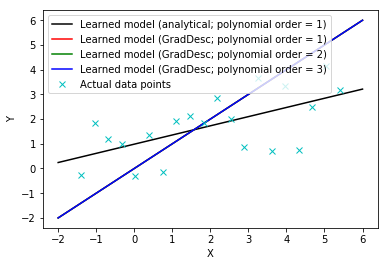

In [30]:
plt.plot(xfit_ana, yfit_ana, 'k-', 
         label='Learned model (analytical; polynomial order = {:d})'.format(fit_poly_order_ana)
        )
plt.plot(xfit_gd_1, xfit_gd_1, 'r-', 
         label='Learned model (GradDesc; polynomial order = 1)'
        )
plt.plot(xfit_gd_2, xfit_gd_2, 'g-', 
         label='Learned model (GradDesc; polynomial order = 2)'
        )
plt.plot(xfit_gd_3, xfit_gd_3, 'b-', 
         label='Learned model (GradDesc; polynomial order = 3)'
        )
plt.plot(X, Y_noisy, 'cx', label='Actual data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.savefig(savedir + 'Q1_15.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 2

Reading and plotting the data.

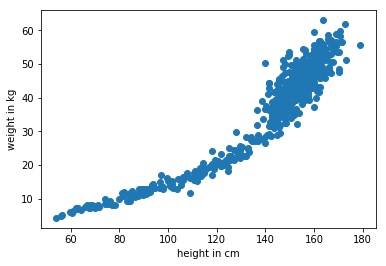

In [31]:
# Read the CSV into a pandas dataframe
raw_data = pd.read_csv(datadir + 'heightweight.csv', header='infer')

# Generate a scatter plot of the data
plt.scatter(raw_data['height'], raw_data['weight']);
plt.xlabel('height in cm')
plt.ylabel('weight in kg')
# plt.savefig(savedir + 'Q2_1.png', dpi=300, bbox_inches='tight')
plt.show()

## Two-parameter regression model to predict weight from height

In [32]:
# The input variable is height, so we load it in X.
X = raw_data['height'].to_numpy()
# We add ones to the data points to prepare for
# two-parameter regression model.
X = np.stack((X, np.ones(X.shape[0])), axis=0)

# The target variable is weight, so we load it in Y.
Y = raw_data['weight'].to_numpy().reshape(-1, 1)

In [33]:
# Next, we create a regression pipeline.
# fit_intercept is set to True because we want to fit 
# the b parameter also.
# n_jobs = 4 launches 4 concurrent jobs to speed up
# the model fitting.
reg = Pipeline([('linreg', LinearRegression(fit_intercept=True, n_jobs=4)),])

In [34]:
# Now, we fit the regression model.
# This should print the pipeline details.
reg.fit(raw_data['height'][:, np.newaxis], raw_data['weight'])

Pipeline(memory=None,
     steps=[('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False))])

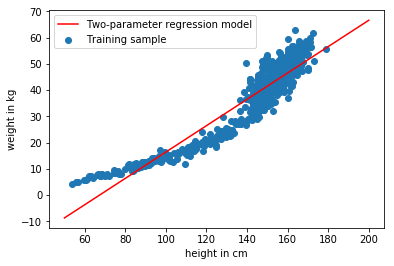

Model slope:     0.5016993362336575
Model intercept: -33.75613690832983


In [35]:
# Finally, we want to visualize the learned model.

# We sample equally spaced points in the range of X.
xfit = np.linspace(50, 200, 1000)

# For these sampled points, we predict the value 
# of Y using the learned model.
yfit = reg.predict(xfit[:, np.newaxis])

# We first plot the original data.
plt.scatter(raw_data['height'], raw_data['weight'], label='Training sample')

# Then we overlay the learned model's predictions
# on top of the plot.
plt.plot(xfit, yfit, 'r-', label='Two-parameter regression model')

plt.xlabel('height in cm')
plt.ylabel('weight in kg')
plt.legend()

# plt.savefig(savedir + 'Q2_2.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model slope:    ", reg.named_steps['linreg'].coef_[0])
print("Model intercept:", reg.named_steps['linreg'].intercept_)

## Visualizing the cost surface of the regression model

Based on the model parameters, we will generate the cost surface in the range [-5, 5] for the slope and [-38, -28] for the intercept.

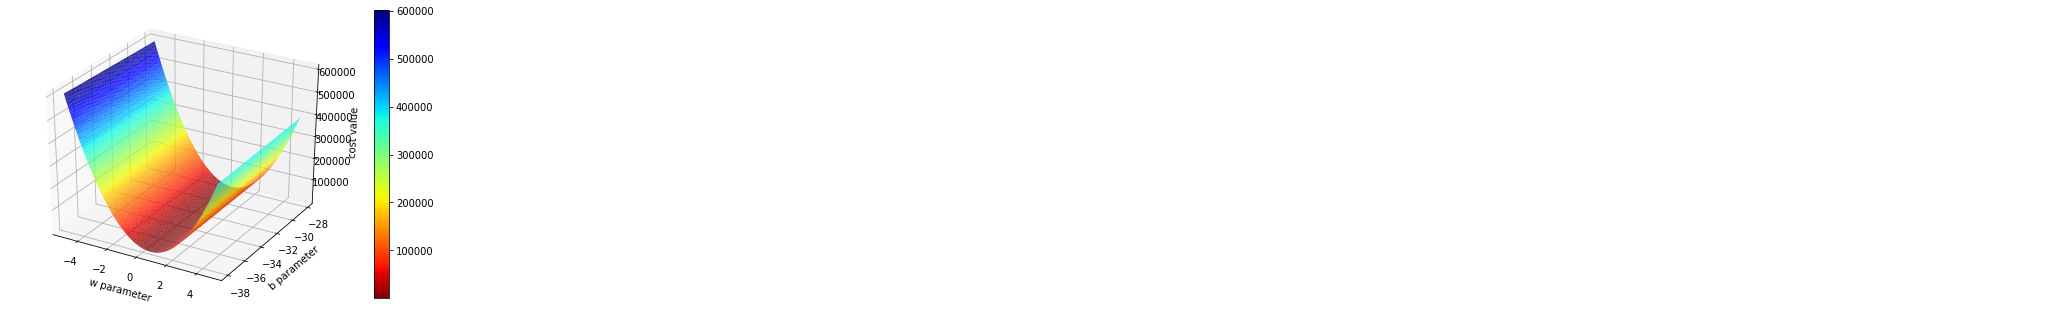

In [36]:
# We set the limits for w and b
# in order to construct a grid.
w_lim = np.arange(-5, 5, 0.1)
b_lim = np.arange(-38, -28, 0.1)

# Then we create the (w,b) grid using
# Cartesian product of w and b values.
params_scan = np.transpose([np.tile(w_lim, len(b_lim)), np.repeat(b_lim, len(w_lim))]).T

# Calculate the model cost for
# each point in the grid.
cost_values = cost_fn(params_scan, X, Y)

# Create a matplotlib 3D figure.
fig = plt.figure()
ax = Axes3D(fig)

# Plot the model cost as a surface.
surf = ax.plot_trisurf(params_scan[0,:], params_scan[1,:], cost_values, cmap='jet_r', linewidth=0.1)

# Add a colorbar for improved readability.
fig.colorbar(surf)
ax.set_xlabel('w parameter')
ax.set_ylabel('b parameter')
ax.set_zlabel('cost value')

# fig.savefig(savedir + 'Q2_3.png', dpi=300, bbox_inches='tight')
plt.show()

## Predicting weight from height using analytical method

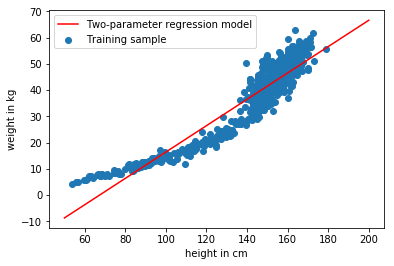

Model slope:     [0.50169934]
Model intercept: [-33.75613691]


In [37]:
# The input variable is height, so we load it in X.
X = raw_data['height'].to_numpy()
# We add ones to the data points to prepare for
# two-parameter regression model.
X = np.stack((X, np.ones(X.shape[0])), axis=0)

# The target variable is weight, so we load it in Y.
Y = raw_data['weight'].to_numpy().reshape(-1, 1)

# Use analytical method to calculate parameters
W_pred_hw = analytical_linreg(X, Y)

# We sample equally spaced points in the range of X.
xfit = np.linspace(50, 200, 1000).T
# We add ones to these to prepare the features.
xfit_feat = np.stack((xfit, np.ones(xfit.shape[0])), axis=0)

# For these sampled points, we predict the value 
# of Y using the learned model.
yfit = xfit_feat.T @ W_pred_hw

# We first plot the original data.
plt.scatter(raw_data['height'], raw_data['weight'], label='Training sample')

# Then we overlay the learned model's predictions
# on top of the plot.
plt.plot(xfit, yfit, 'r-', label='Two-parameter regression model')
plt.xlabel('height in cm')
plt.ylabel('weight in kg')
plt.legend()

# plt.savefig(savedir + 'Q2_4.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model slope:    ", W_pred_hw[0])
print("Model intercept:", W_pred_hw[1])

## Predicting weight from age using analytical method

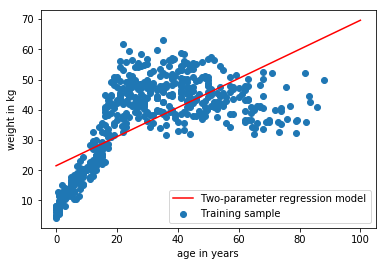

Model slope:     [0.48125474]
Model intercept: [21.48848913]


In [38]:
# The input variable is weight, so we load it in X.
X = raw_data['age'].to_numpy()
# We add ones to the data points to prepare for
# two-parameter regression model.
X = np.stack((X, np.ones(X.shape[0])), axis=0)

# The target variable is weight, so we load it in Y.
Y = raw_data['weight'].to_numpy().reshape(-1, 1)

# Use analytical method to calculate parameters
W_pred_aw = analytical_linreg(X, Y)

# We sample equally spaced points in the range of X.
xfit = np.linspace(0, 100, 1000).T
# We add ones to these to prepare the features.
xfit_feat = np.stack((xfit, np.ones(xfit.shape[0])), axis=0)

# For these sampled points, we predict the value 
# of Y using the learned model.
yfit = xfit_feat.T @ W_pred_aw

# We first plot the original data.
plt.scatter(raw_data['age'], raw_data['weight'], label='Training sample')

# Then we overlay the learned model's predictions
# on top of the plot.
plt.plot(xfit, yfit, 'r-', label='Two-parameter regression model')
plt.xlabel('age in years')
plt.ylabel('weight in kg')
plt.legend()

# plt.savefig(savedir + 'Q2_5.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model slope:    ", W_pred_aw[0])
print("Model intercept:", W_pred_aw[1])

## Predicting weight from all of height, age, and sex using analytical method

In [39]:
# We select all three columns: height, age, and sex,
# and load it as a NumPy array X.
X = raw_data[['height', 'age', 'male']].to_numpy()
# We add ones to this to prepare the features.
X = np.hstack((X, np.ones((X.shape[0], 1)))).T

# The target variable is weight, so we load it in Y.
Y = raw_data['weight'].to_numpy().reshape(-1, 1)

# Use analytical method to calculate parameters
W_aall = analytical_linreg(X, Y)

print("Coefficient of height:", W_aall[0])
print("Coefficient of age:   ", W_aall[1])
print("Coefficient of sex:   ", W_aall[2])
print("Coefficient of b:     ", W_aall[3])

Coefficient of height: [0.4734134]
Coefficient of age:    [0.05050421]
Coefficient of sex:    [0.92548938]
Coefficient of b:      [-31.76446244]
